In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pycaret.regression import *
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import random
import matplotlib.ticker as mtick
import re

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from neighborhoods import admin_wards
from neighborhoods import district_neighborhoods

In [2]:
random.seed(42)

In [3]:
# Load the dataset
df = pd.read_csv('../data/processed/additional_data.csv')
df.shape

(15975, 9)

In [4]:
def drop_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [5]:
df = df.drop_duplicates()
df = df.replace({True: 1, False: 0})
df['district'] = df['district'].replace('Arganzuela', 'arganzuela')

df = drop_outliers_iqr(df, 'price')


In [6]:
def has_weird_characters(input_string):
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    return bool(pattern.search(input_string))

def replace_str_values(df, column, input_tuple_list):
    for item in input_tuple_list:
        df[column] = df[column].str.replace(item[0], item[1])
    return df


In [7]:
input_tuple_list = [('Virgen del Cortijo', 'Valdefuentes'), ('Tablas', 'Valverde'), ('Tablas', 'Valverde'), ('Sanchinarro', 'Valdefuentes'), ('Montecarmelo', 'Mirasierra'), ('Arroyo del Fresno', 'Mirasierra'), ('Buena Vista', 'Buenavista'), ('Ambroz', 'Casco Histórico de Vicálvaro'), ('Águilas', 'Las Águilas'), ('-', ' '), ('Ã³', 'ó'), ('Ã¼', 'ü'),  ('Ã©', 'é'), ('Ã±', 'ñ'), ('Ã\xad', 'í'), ('Ã\x81', 'Á'), ('Ãº', 'ú'),  ('Ã¡', 'á')]

In [8]:
df = replace_str_values(df, 'neighborhood', input_tuple_list)


df['neighborhood'] = df['neighborhood'].replace('Chalet en Águilas', 'Las Águilas')
df['neighborhood'] = df['neighborhood'].replace('Águilas', 'Las Águilas')

for item in df['neighborhood'].values:
    for barrio in admin_wards:
        if barrio in item:
            df['neighborhood'] = df['neighborhood'].replace(item, barrio)

In [9]:
not_barrios = []


for item in df['neighborhood'].values:
    if item not in admin_wards:
        not_barrios.append(item)


set(not_barrios), len(set(df['neighborhood'].values))

({'Los Berrocales', 'Palomeras sureste', 'Pau de Carabanchel'}, 129)

In [10]:
df.shape

(12975, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12975 entries, 0 to 15974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12975 non-null  int64  
 1   house_type    12975 non-null  object 
 2   house_type_2  12521 non-null  object 
 3   rooms         12975 non-null  int64  
 4   m2            12975 non-null  float64
 5   elevator      12975 non-null  int64  
 6   garage        12975 non-null  int64  
 7   neighborhood  12975 non-null  object 
 8   district      12975 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 1013.7+ KB


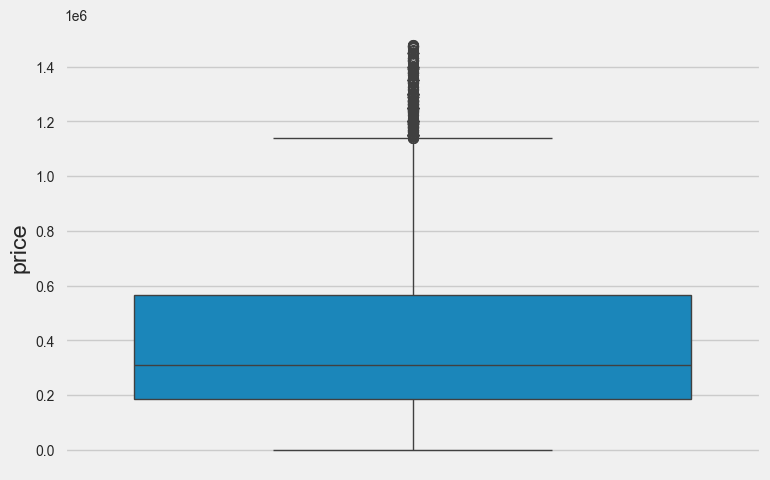

In [12]:
sns.boxplot(df['price'])
plt.show()

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
df.columns

Index(['price', 'house_type', 'house_type_2', 'rooms', 'm2', 'elevator',
       'garage', 'neighborhood', 'district'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12975 entries, 0 to 15974
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12975 non-null  int64  
 1   house_type    12975 non-null  object 
 2   house_type_2  12521 non-null  object 
 3   rooms         12975 non-null  int64  
 4   m2            12975 non-null  float64
 5   elevator      12975 non-null  int64  
 6   garage        12975 non-null  int64  
 7   neighborhood  12975 non-null  object 
 8   district      12975 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 1013.7+ KB


In [16]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

In [17]:
df_corr = pd.DataFrame(df[numerical_features].corr()['price'])
df_corr['price'] = df_corr['price'].apply(lambda x: abs(x))
df_corr.sort_values(by='price', ascending=False)

,price
price,1.000000
m2,0.773151
rooms,0.490906
elevator,0.363338
garage,0.274575


In [18]:
# Define features and target variable
X = df[[column for column in df.columns if column != 'price']]
y = df['price']

In [19]:
# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Initialize models
logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

ridge_classifier_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeClassifier())
])

lasso_logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='saga'))
])

elastic_net_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet())
])

# Train and evaluate


In [20]:
# Setup the environment in PyCaret
regression_setup = setup(
    data=df,
    target = 'price',
    ignore_features=[],
    numeric_imputation = 'mean',
    categorical_imputation = 'mode',
    remove_multicollinearity=True,
    transformation= True,
    transformation_method = 'yeo-johnson',
    normalize = True,
    normalize_method = 'zscore'
)

,Description,Value
0,Session id,1974
1,Target,price
2,Target type,Regression
3,Original data shape,"(12975, 9)"
4,Transformed data shape,"(12975, 29)"
5,Transformed train set shape,"(9082, 29)"
6,Transformed test set shape,"(3893, 29)"
7,Numeric features,4
8,Categorical features,4
9,Rows with missing values,3.5%


In [21]:
# compare baseline models
best_model = compare_models(exclude=['lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,62962.1025,9384326484.9269,96735.9671,0.9040,0.2106,0.1888,0.2410
lightgbm,Light Gradient Boosting Machine,65129.8963,10032028227.5043,100013.3089,0.8974,0.2168,0.1941,0.5690
xgboost,Extreme Gradient Boosting,64692.4409,10212953985.4322,100900.1828,0.8955,0.2149,0.1901,0.0410
et,Extra Trees Regressor,63595.3896,10417654888.2689,101928.2320,0.8934,0.2204,0.1906,0.1930
rf,Random Forest Regressor,65371.4850,10644930200.8912,103011.8387,0.8912,0.2221,0.1960,0.2120
gbr,Gradient Boosting Regressor,71616.7065,11647555181.1563,107776.0531,0.8809,0.2365,0.2146,0.0800
knn,K Neighbors Regressor,77280.6216,14627243813.8750,120752.1128,0.8503,0.2506,0.2197,0.0380
dt,Decision Tree Regressor,83727.0375,18818832984.9773,137060.3556,0.8073,0.2991,0.2476,0.0330
ridge,Ridge Regression,104828.2835,20295306391.2511,142382.7401,0.7922,0.5661,0.3614,0.0300
llar,Lasso Least Angle Regression,104830.9457,20295337703.1718,142382.8391,0.7922,0.5665,0.3614,0.0290


In [22]:
n_iter=50

best_model = tune_model(best_model, n_iter=n_iter, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,62985.6441,8771124881.6266,93654.2838,0.9113,0.1944,0.1577
1,64103.6740,9818896160.2156,99090.3434,0.8986,0.1984,0.1580
2,63559.8554,10347962258.6081,101724.9343,0.8956,0.2026,0.1576
3,66620.6965,10920485587.6614,104501.1272,0.8942,0.2077,0.1595
4,64980.2122,9748035831.9091,98732.1418,0.8987,0.2097,0.1683
5,62016.4554,9216051228.3487,96000.2668,0.9001,0.2051,0.1627
6,68883.9874,10655859681.2542,103227.2235,0.8971,0.2161,0.1705
7,61288.2257,9485525617.9328,97393.6631,0.9021,0.2197,0.1709
8,61456.3166,8501525680.8157,92203.7184,0.9138,0.2697,0.4411


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
best_model = tune_model(best_model, search_library = 'optuna', n_iter=n_iter, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,62610.0717,8866111745.6388,94160.0326,0.9103,0.1933,0.1566
1,64097.7177,10108045723.9740,100538.7772,0.8956,0.1969,0.1561
2,62146.1803,10087285976.7030,100435.4817,0.8982,0.1985,0.1537
3,65760.1280,10976510221.4580,104768.8418,0.8936,0.2049,0.1573
4,63702.2095,9625008254.8930,98107.1264,0.9000,0.2087,0.1668
5,62013.9249,9296473456.4084,96418.2216,0.8993,0.2054,0.1628
6,68062.8792,10549531747.5297,102710.9135,0.8981,0.2137,0.1672
7,61077.8465,9562090988.7398,97785.9447,0.9013,0.2187,0.1699
8,61196.3127,8461598956.6974,91986.9499,0.9142,0.2696,0.4370


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [24]:
best_model = tune_model(best_model, search_library = 'scikit-optimize', n_iter=n_iter, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,62889.5839,8808133212.0875,93851.6554,0.9109,0.1936,0.1565
1,64152.7544,10290328043.0926,101441.2541,0.8937,0.1996,0.1574
2,63151.2810,10222163525.1194,101104.7156,0.8969,0.1999,0.1557
3,66238.8893,11124422765.7581,105472.3792,0.8922,0.2081,0.1596
4,63596.1878,9426379177.5243,97089.5421,0.9021,0.2099,0.1660
5,61689.7408,9262694136.5724,96242.8914,0.8996,0.2046,0.1622
6,67639.8499,10443087775.3859,102191.4271,0.8991,0.2125,0.1649
7,61238.3713,9586415358.3533,97910.2413,0.9011,0.2171,0.1689
8,61297.7140,8514725384.9060,92275.2696,0.9136,0.2704,0.4369


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [25]:
best_model = ensemble_model(best_model, method = 'Bagging', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,63220.9558,8849191943.6886,94070.1437,0.9105,0.1937,0.1564
1,64148.9987,9797771283.9603,98983.6920,0.8988,0.1979,0.1579
2,63451.8221,10572606019.9651,102823.1784,0.8933,0.2005,0.1564
3,66263.6554,10981132074.9608,104790.8969,0.8936,0.2051,0.1581
4,64276.6721,9471905280.6996,97323.7139,0.9016,0.2075,0.1664
5,61850.4936,9237094530.5909,96109.8045,0.8999,0.2037,0.1623
6,68745.7885,10685664875.8746,103371.4897,0.8968,0.2138,0.1680
7,61386.4578,9371931697.4199,96808.7377,0.9033,0.2162,0.1690
8,60947.2720,8357222583.4191,91417.8461,0.9152,0.2687,0.4407


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [26]:
best_model = ensemble_model(best_model, method = 'Boosting', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,65785.6432,9290359403.4967,96386.5105,0.9060,0.1999,0.1662
1,66733.9191,10131135231.9638,100653.5406,0.8954,0.2043,0.1671
2,65672.2764,10365435490.9184,101810.7828,0.8954,0.2077,0.1670
3,68981.7262,11331624549.8171,106450.1036,0.8902,0.2143,0.1695
4,65181.0869,9378843504.9071,96844.4294,0.9026,0.2165,0.1757
5,65194.4939,9931048516.3179,99654.6462,0.8924,0.2161,0.1759
6,70092.5653,10598546704.9343,102949.2433,0.8976,0.2186,0.1756
7,63742.2334,9765409961.8879,98820.0889,0.8992,0.2225,0.1790
8,63399.7028,8563565947.0755,92539.5372,0.9131,0.2747,0.4510


Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [27]:
best_mae_models_top3 = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,62962.1025,9384326484.9269,96735.9671,0.9040,0.2106,0.1888,0.1940
et,Extra Trees Regressor,63595.3896,10417654888.2689,101928.2320,0.8934,0.2204,0.1906,0.1980
xgboost,Extreme Gradient Boosting,64692.4409,10212953985.4322,100900.1828,0.8955,0.2149,0.1901,0.0410
lightgbm,Light Gradient Boosting Machine,65129.8963,10032028227.5043,100013.3089,0.8974,0.2168,0.1941,0.5580
rf,Random Forest Regressor,65371.4850,10644930200.8912,103011.8387,0.8912,0.2221,0.1960,0.2220
gbr,Gradient Boosting Regressor,71616.7065,11647555181.1563,107776.0531,0.8809,0.2365,0.2146,0.0830
knn,K Neighbors Regressor,77280.6216,14627243813.8750,120752.1128,0.8503,0.2506,0.2197,0.0420
dt,Decision Tree Regressor,83727.0375,18818832984.9773,137060.3556,0.8073,0.2991,0.2476,0.0340
par,Passive Aggressive Regressor,101027.0351,22314594827.9200,149273.3082,0.7716,0.5037,0.3127,0.0690
huber,Huber Regressor,101162.0288,21544338355.4519,146680.1455,0.7795,0.5397,0.3234,0.0350


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 495
[LightGBM] [Info] Number of data points in the train set: 8173, number of used features: 28
[LightGBM] [Info] Start training from score 423557.512297
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whit

In [28]:
best_model = blend_models(best_mae_models_top3, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61003.5645,8525063314.4170,92331.2694,0.9137,0.1884,0.1518
1,62484.6606,9578258042.1590,97868.5754,0.9011,0.1920,0.1521
2,60737.3337,10197103590.7003,100980.7090,0.8971,0.1935,0.1487
3,63580.8063,10560419176.7521,102763.9002,0.8977,0.2013,0.1529
4,63404.2540,9268585238.8558,96273.4919,0.9037,0.2068,0.1649
5,60766.1115,9243452651.0711,96142.8762,0.8998,0.1973,0.1557
6,66098.7548,10237224012.0888,101179.1679,0.9011,0.2097,0.1629
7,59465.0757,9353764272.2443,96714.8607,0.9035,0.2130,0.1646
8,58651.3492,8102246603.0797,90012.4803,0.9178,0.2643,0.4189


In [29]:
best_model = stack_models(best_mae_models_top3, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61061.9684,8431539635.2059,91823.4155,0.9147,0.1883,0.1518
1,62563.9399,9526980199.7359,97606.2508,0.9016,0.1927,0.1521
2,60913.8580,10058055171.0719,100289.8558,0.8985,0.1933,0.1488
3,63678.2340,10583271319.4619,102875.0277,0.8974,0.2015,0.1525
4,62907.1089,9120855590.5009,95503.1706,0.9052,0.2046,0.1630
5,60566.9471,8990075074.4975,94816.0064,0.9026,0.1981,0.1561
6,66076.4965,10100900128.6225,100503.2344,0.9024,0.2085,0.1626
7,59550.1054,9180016836.8747,95812.4044,0.9053,0.2127,0.1646
8,58639.0830,7971718546.5576,89284.4810,0.9191,0.2644,0.4222


In [30]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

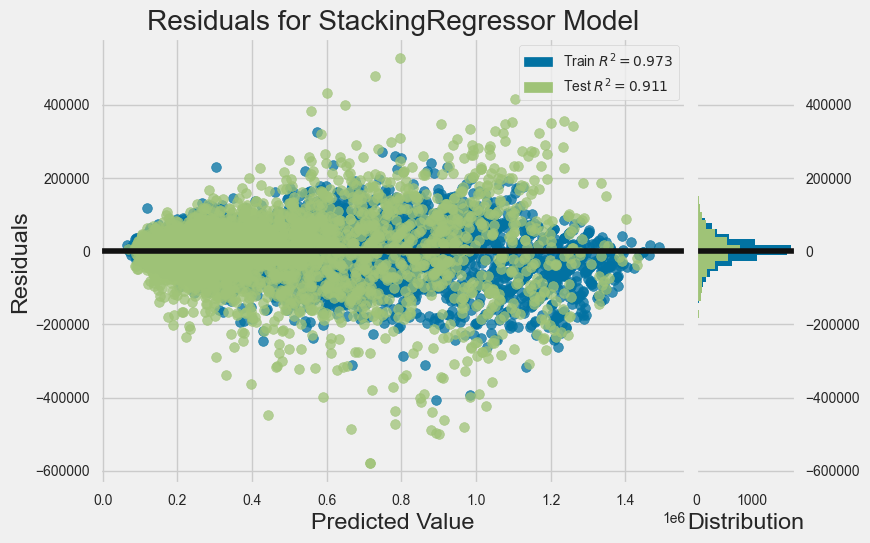

In [31]:
plot_model(best_model, plot = 'residuals')

In [ ]:
plot_model(best_model, plot = 'error')

In [ ]:
plot_model(best_model, plot = 'feature')

In [ ]:
plot_model(best_model, plot = 'learning')

In [ ]:
sns.heatmap(df[numerical_features].corr())

In [ ]:
cluster_errors = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters, random_state=42, verbose=0))
    ])
    kmeans_pipeline.fit(X)
    wcsse = kmeans_pipeline.named_steps["cluster"].inertia_
    print('K = ', n_clusters, '\tWCSS Err. = ', wcsse)
    cluster_errors.append(wcsse)

plt.plot(range(2, 11), cluster_errors, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
silhouette_s = []

for n_clusters in range(2, 11):
    kmeans_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("pca", PCA(10, svd_solver='arpack')),
        ("cluster", KMeans(n_clusters=n_clusters))])
    df_X = kmeans_pipeline.fit_transform(X)
    cluster_labels = kmeans_pipeline.fit_predict(X)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_score(df_X, cluster_labels).round(4))
    silhouette_s.append(silhouette_score(df_X, cluster_labels))

plt.plot(range(2, 11),silhouette_s, "o-")
plt.xlabel("No. Clusters")
plt.ylabel("Silhouette Score")
plt.show()


In [ ]:
pipe_pca_kmean = Pipeline(
        [
          ('preprocessor', preprocessor),
          ('pca', PCA(10, svd_solver='arpack')),
          ("cluster", KMeans(n_clusters=3, verbose=0))
        ]
    )
pipe_pca_kmean.fit(X)
pipe_pca_kmean.predict(X)

In [ ]:
kmean_cluster = pd.DataFrame(
    data = pipe_pca_kmean.named_steps["cluster"].labels_,
    index = X.index,
    columns=['kmean_cluster']
)

In [ ]:
kmean_cluster

In [ ]:
kmean_cluster['kmean_cluster'].value_counts()

In [ ]:
X['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [ ]:
df['kmean_cluster'] = kmean_cluster['kmean_cluster'].copy()

In [ ]:
df['price'] = df['price'].apply(lambda x: round(x, 2))
pd.options.display.float_format = '{:.2f}'.format

df_combined_describe_dict = {}
columns = []

df_0 = df[df['kmean_cluster']==0]
df_0_y_describe = df_0['price'].describe()
df_combined_describe_dict['df_0'] = df_0_y_describe
columns.append(('Price', 'Cluster 0'))

df_1 = df[df['kmean_cluster']==1]
df_1_y_describe = df_1['price'].describe()
df_combined_describe_dict['df_1'] = df_1_y_describe
columns.append(('Price', 'Cluster 1'))

df_2 = df[df['kmean_cluster']==2]
df_2_y_describe = df_2['price'].describe()
df_combined_describe_dict['df_2'] = df_2_y_describe
columns.append(('Price', 'Cluster 2'))

df_combined_describe = pd.DataFrame(df_combined_describe_dict)

multi_index = pd.MultiIndex.from_tuples(columns)

df_combined_describe.columns = multi_index

df_combined_describe

In [ ]:
tsne = Pipeline(
        [
          ('preprocessor', preprocessor),
          ("tsne", TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init='random')),
        ]
    )

X_tsne = tsne.fit_transform(X)

In [ ]:
le = LabelEncoder()

In [ ]:
nrows = 8
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (15, 40))

axs = axs.flatten()

le = LabelEncoder()

for i, column in enumerate(X.columns):
    if i >= len(axs):
        break
    ax = axs[i]
    if column in categorical_features:
        encoded_column = le.fit_transform(df[column])
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_column, cmap=plt.cm.Spectral, alpha=0.3)
    else:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[column], cmap=plt.cm.Spectral, alpha=0.3)

    ax.set_title(f'{column} - t-SNE Projected data')
    ax.axis('tight')
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
df_0.columns

In [ ]:
num_features_plot = ['price', 'm2']

In [ ]:
def plot_clusters(column, df_list, numerical_features, rotate=False):
    print(rotate)
    if column in numerical_features:
        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111)
        for i, df in enumerate(df_list):
            sns.kdeplot(data=df, x=column, ax=ax, label=f'Cluster {i}', shade=True)
        ax.set_title(f'KDE Plot - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()
        if rotate:
            plt.xticks(rotation=360)
    else:
        cluster_colors = ['#69ACD9', '#E8917D', '#E2C480']
        combined_df = pd.concat([df.assign(cluster=i) for i, df in enumerate(df_list)])
        proportions = combined_df.groupby([column, 'cluster']).size().reset_index(name='count')
        proportions['proportion'] = proportions.groupby(column)['count'].apply(lambda x: x / float(x.sum()))
        pivot_df = proportions.pivot(index=column, columns='cluster', values='proportion').fillna(0)
        pivot_df = pivot_df.sort_values(by=0)
        fig, ax = plt.subplots(figsize=(20, 5))
        pivot_df.plot(kind='bar', stacked=True, ax=ax, color=cluster_colors[:pivot_df.shape[1]])
        ax.set_title(f'Relative Proportions - {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Proportion')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        if rotate:
            plt.xticks(rotation=90)
        else:
            plt.xticks(rotation=0)
    plt.show()

In [ ]:
plot_clusters('price', [df_0, df_1, df_2], num_features_plot)

In [ ]:
plot_clusters('m2', [df_0, df_1, df_2], num_features_plot)

In [ ]:
plot_clusters('house_type_2', [df_0, df_1, df_2], num_features_plot, True)

In [ ]:
plot_clusters('rooms', [df_0, df_1, df_2], num_features_plot)